# Explore here

Column description
- Pregnancies. Number of pregnancies of the patient (numeric)
- Glucose. Plasma glucose concentration 2 hours after an oral glucose tolerance test (numeric)
- BloodPressure. Diastolic blood pressure (measured in mm Hg) (numeric)
- SkinThickness. Triceps skin fold thickness (measured in mm) (numeric)
- Insulin. 2-hour serum insulin (measured in mu U/ml) (numeric)
- BMI. Body mass index (numeric)
- DiabetesPedigreeFunction. Diabetes Pedigree Function (numeric)
- Age. Age of patient (numeric)
- Outcome. Class variable (0 or 1), being 0 negative in diabetes and 1 positive (numeric)

### Step 1: Load Required Libraries
This step imports necessary libraries for data manipulation, visualization, and machine learning.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV


### Step 2: Load and Inspect the Dataset
The dataset is loaded from a CSV file. We print the first few rows, summary statistics, and data types to understand its structure.

In [2]:
diabetes_data = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv')
print(diabetes_data.head())  # Display first few rows
print(diabetes_data.info())  # Data types and missing values
print(diabetes_data.describe())  # Summary statistics

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768

### Step 3: Handle Duplicate Values
Check for duplicate rows and remove them if any exist.

In [3]:
print(f'Duplicate values: {diabetes_data.duplicated().sum()}')
if diabetes_data.duplicated().sum() != 0:
    diabetes_data.drop_duplicates(inplace=True)

Duplicate values: 0


### Step 4: Handle Outliers and Missing Values
Replace zero values in select columns with NaN and fill them with the median

In [4]:
invalid_zero_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
diabetes_data[invalid_zero_columns] = diabetes_data[invalid_zero_columns].replace(0, np.nan)
for col in invalid_zero_columns:
    diabetes_data[col] = diabetes_data[col].fillna(diabetes_data[col].median())

# Adjust extreme insulin values.

In [5]:
highest_insulin = diabetes_data[diabetes_data['Insulin'] == 846]
diabetes_data.loc[highest_insulin.index, 'Insulin'] = diabetes_data["Insulin"].median()

print(diabetes_data.isnull().sum())  # Confirm missing values handled
print(diabetes_data.describe())  # Recheck statistics

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  121.656250      72.386719      29.108073  139.733073   
std       3.369578   30.438286      12.096642       8.791221   82.540025   
min       0.000000   44.000000      24.000000       7.000000   14.000000   
25%       1.000000   99.750000      64.000000      25.000000  121.500000   
50%       3.000000  117.000000      72.000000      29.000000  125.000000   
75%       6.000000  140.250000      80.000000      32.000000  126.250000   
max      17.000000  199.000000     122.000000      99.000000  744.000000   

              BMI  DiabetesPedig

### Step 5: Univariate Data Analysis
Visualize distributions of numerical variables.
#### Observations:
 - Glucose, BMI, and Age show normal-like distributions with some skewness.
 - Insulin has a right-skewed distribution with extreme values.
 - Box plots indicate the presence of potential outliers, particularly in Insulin and BMI.
 - Higher glucose levels are more common among diabetic patients.

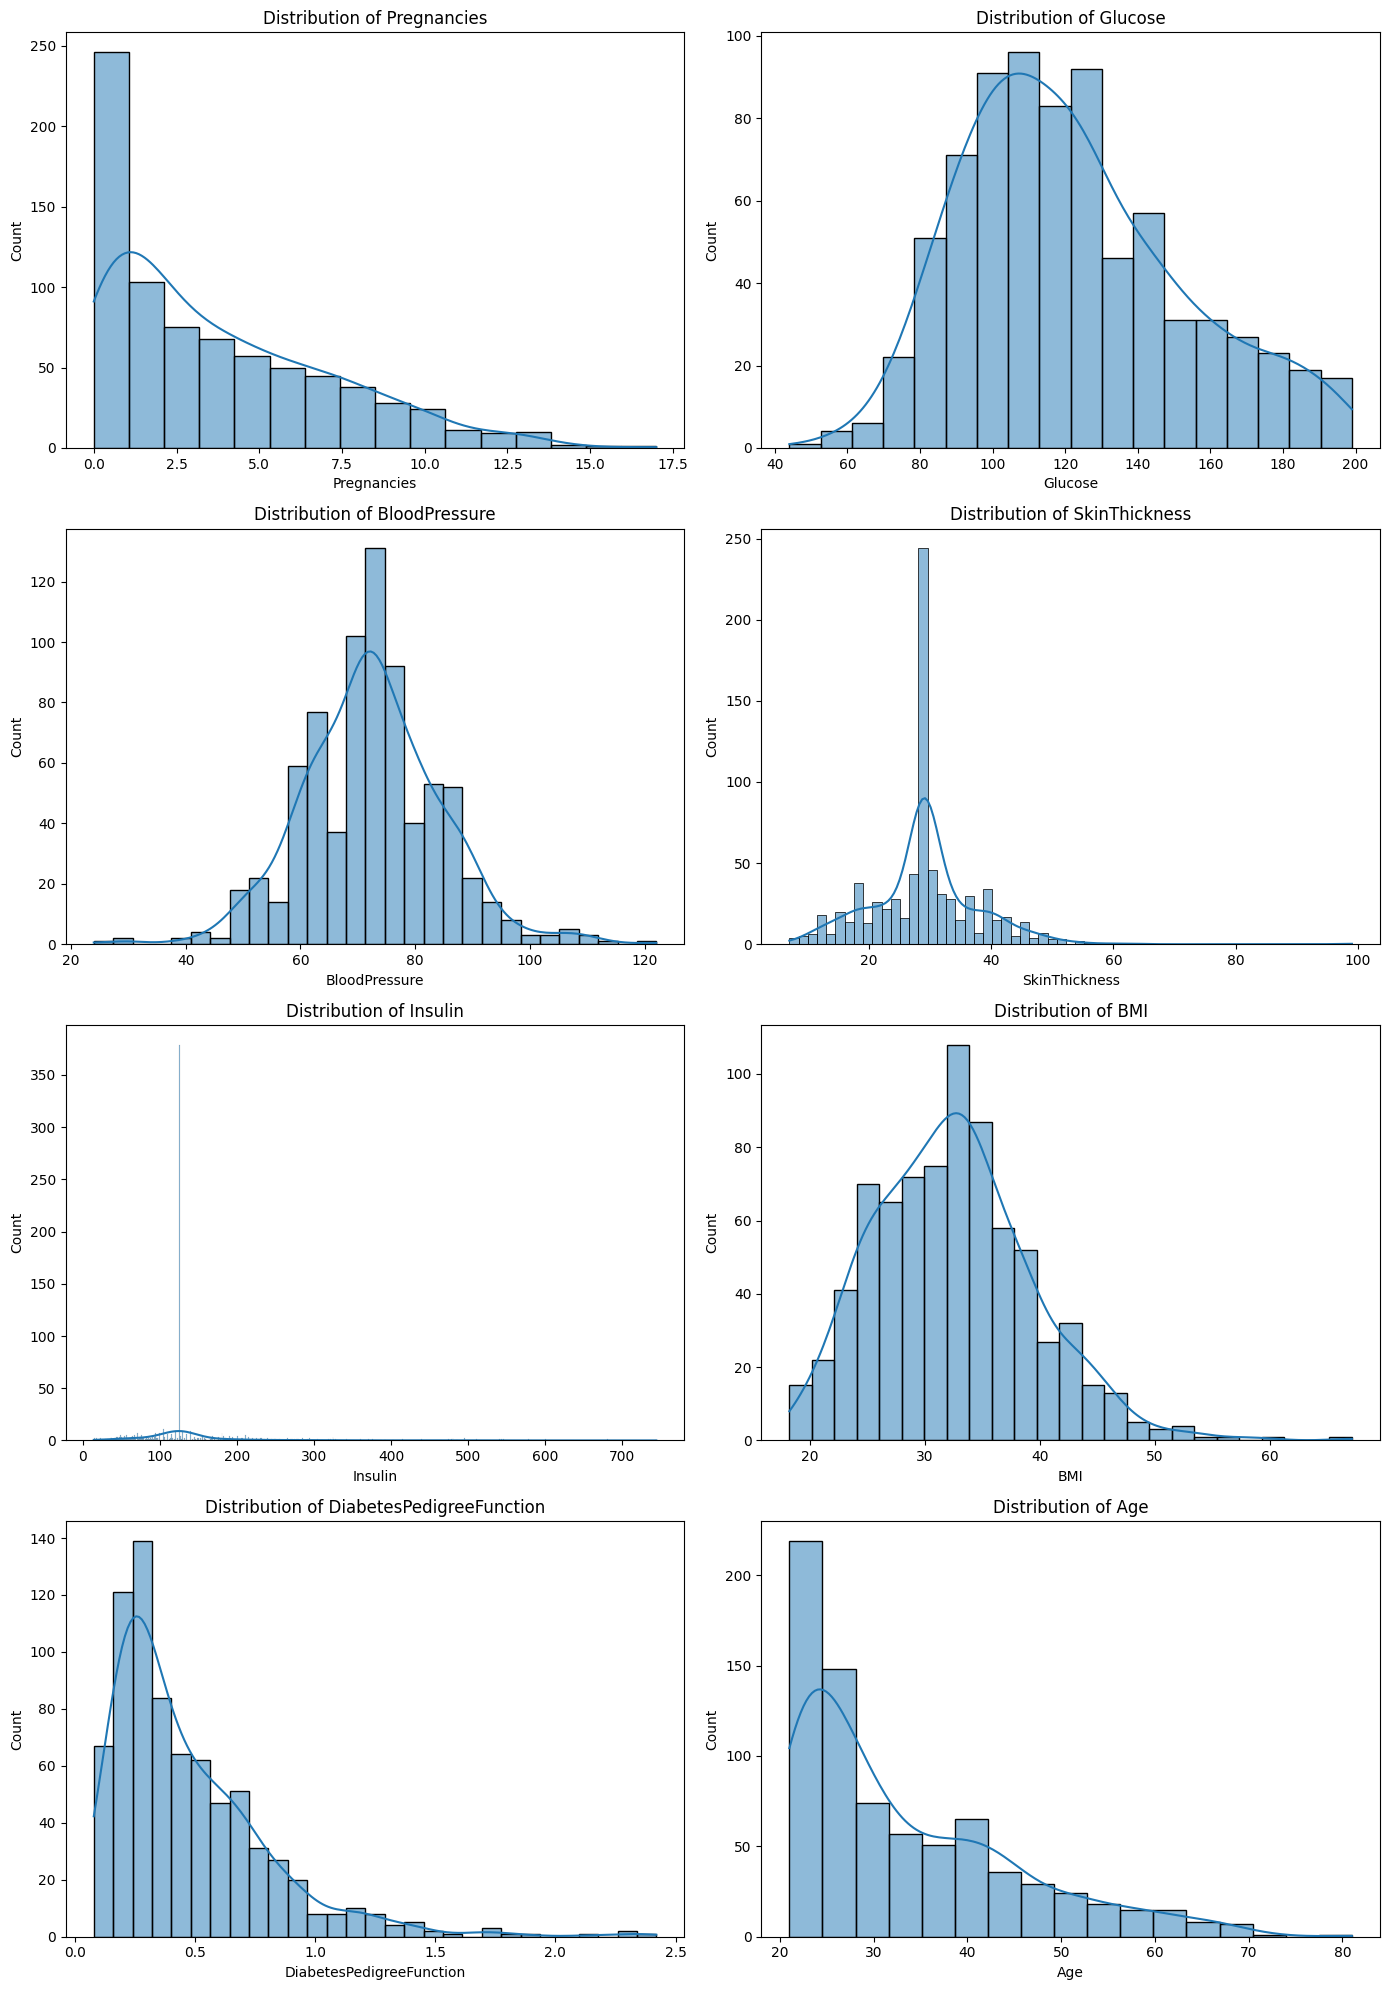

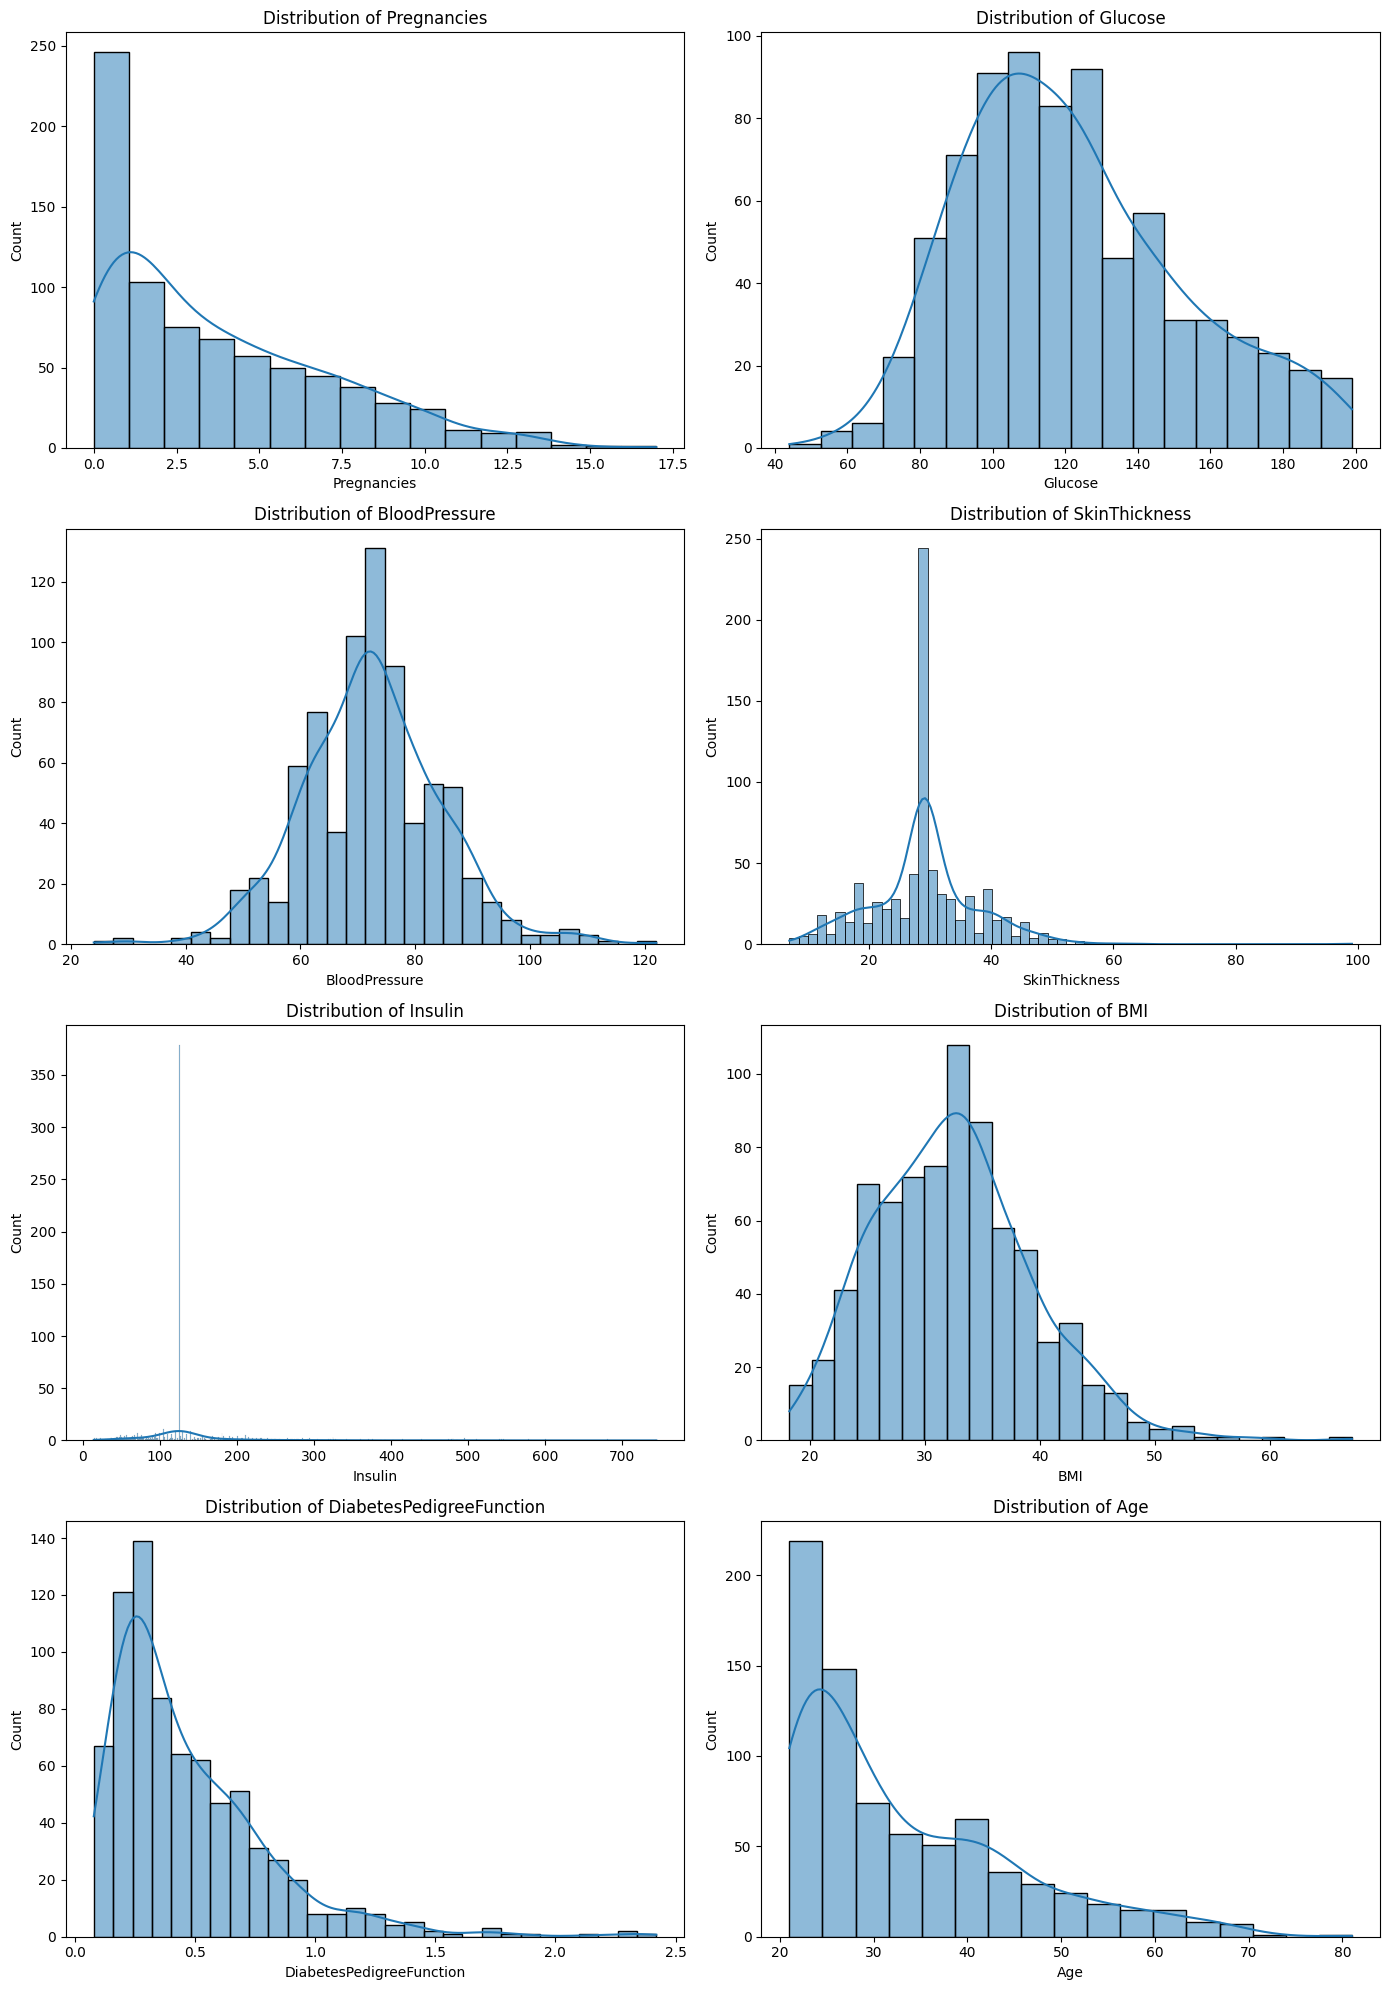

In [6]:
fig, axes = plt.subplots(4, 2, figsize=(14, 20))
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
for i, feature in enumerate(features):
    sns.histplot(data=diabetes_data, x=feature, kde=True, ax=axes[i // 2, i % 2])
    axes[i // 2, i % 2].set_title(f"Distribution of {feature}")
plt.tight_layout()
plt.show()
# Visualize distributions of numerical variables.
fig, axes = plt.subplots(4, 2, figsize=(14, 20))
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
for i, feature in enumerate(features):
    sns.histplot(data=diabetes_data, x=feature, kde=True, ax=axes[i // 2, i % 2])
    axes[i // 2, i % 2].set_title(f"Distribution of {feature}")
plt.tight_layout()
plt.show()

### Step 6: Multivariate Data Analysis
Analyze relationships between features using correlation heatmap.
#### Observations:
 - Glucose shows a strong positive correlation with diabetes outcome, making it a key predictor.
 - BMI and Age also have moderate correlations with the Outcome variable.
 - The heatmap confirms a strong link between Insulin and SkinThickness, likely due to their medical relationship.

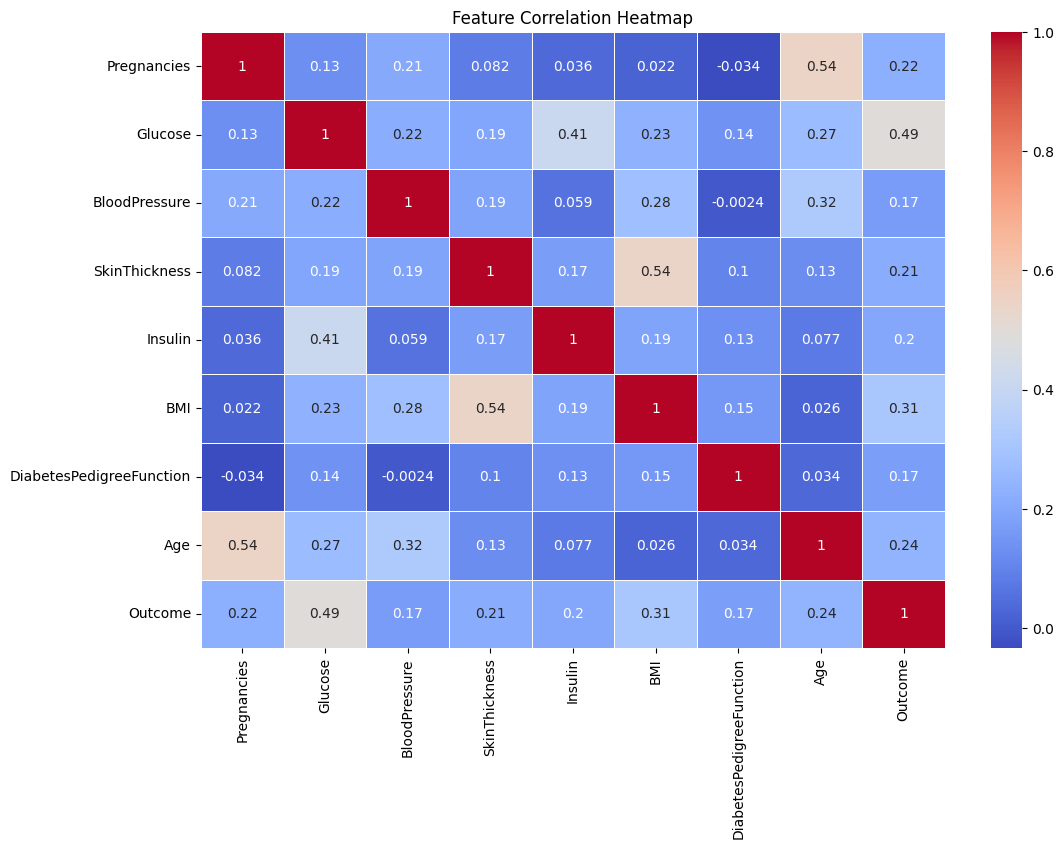

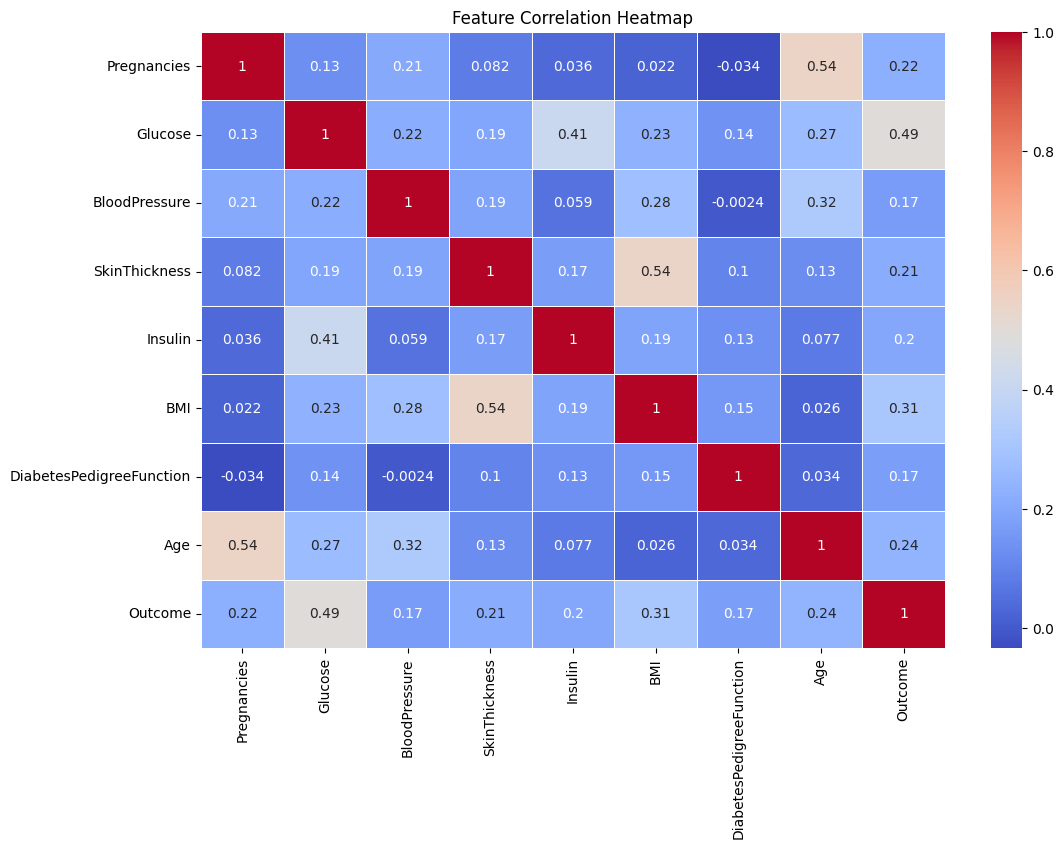

In [7]:
plt.figure(figsize=(12, 8))
sns.heatmap(diabetes_data.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()
# Analyze relationships between features using correlation heatmap.
plt.figure(figsize=(12, 8))
sns.heatmap(diabetes_data.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

### Step 7: Train-Test Split
Split the dataset into training and test sets for model evaluation.

In [8]:
X = diabetes_data.drop(['Outcome'], axis=1)
y = diabetes_data['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=117)


### Step 8: Train XGBoost Model
Fit a XGBoost model on the training data.

In [9]:
from xgboost import XGBClassifier

model = XGBClassifier(random_state=117)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

### Step 9: Evaluate Model Performance
Calculate accuracy of the trained model.

In [10]:
model_accuracy = accuracy_score(y_test, y_pred)
print(f'✅ Initial Model Accuracy: {model_accuracy:.4f}')

✅ Initial Model Accuracy: 0.7468


### Step 10: Hyperparameter Tuning
Optimize the model using GridSearchCV.

In [11]:
from sklearn.model_selection import GridSearchCV

hyperparams = hyperparams = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2, 0.5],
    'max_depth': [3, 5, 7,10],
    'subsample': [0.8, 1.0], 
    'colsample_bytree': [0.8, 1.0]
}

grid = GridSearchCV(model, hyperparams, scoring='accuracy', cv=5)


import warnings
warnings.simplefilter("ignore")

grid.fit(X_train, y_train)
print(f'✅ Best Hyperparameters: {grid.best_params_}')

✅ Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}


### Step 11: Train Optimized Model
Train a new model with the best hyperparameters.

In [12]:
opt_model = XGBClassifier(**grid.best_params_)
opt_model.fit(X_train, y_train)
opt_pred = opt_model.predict(X_test)

opt_accuracy = accuracy_score(y_test, opt_pred)
print(f'✅ Optimized Model Accuracy: {opt_accuracy:.4f}')

✅ Optimized Model Accuracy: 0.7403


## Step 12: Save the Model

In [14]:
from pickle import dump

dump(model, open("../models/boosting_classifier_random_state_117.sav", "wb"))